# Набор данных

[Набор данных](https://drive.google.com/file/d/1qCMvjO0GlNk1WCu7HKn5W8vUNVdJ7eZD/view?usp=share_link) -- запись 2.2 часов игры в простую мини игру obstacles, целью которой является преодоление случайных препятствий (см. [видео](https://drive.google.com/file/d/1aUN1821DvO3V1zxNGBBkSVJ6e93_SxuZ/view?usp=share_link) для примера). Состояние игры сохранялось каждые 50 мс (1 игровой тик).

Целевой признак: будет ли в этот игровой тик поставлен красный блок (`placed_block`), допустимо предсказывать, будет ли поставлен блок в ближайшие _несколько_ игровых тиков.

Другие признаки:
- держит ли игрок блок (`holds_block`)
- координаты игрока (`x`, `y`, `z`)
- угол поворота камеры относительно осей координат в градусах (`yaw`, `pitch`)
- может ли игрок летать (`can_fly`)
  - `true` во время возрождения
- координаты блока, который игрок сейчас может поставить (`x_block`, `y_block`, `z_block`)
  - `NaN`, если игрок не смотрит на блок
- упал ли игрок только что в бездну (`missclick`)
  - допустимо игнорировать данные в течение 3 секунд предшествующих записи с этим флагом
- какие клавиши нажаты (`key_forward`, `key_back`, `key_left`, `key_right`, `key_jump`, `key_sneak`)
- стою ли игрок на блоке (`on_ground`)
- находятся ли блоки в кубе 5x5x5 блоков вокруг игрока (`player[x][y][z]`, где $x, y, z \in \{-2, -1, 0, 1, 2\}$)
- находятся ли блоки в кубе 5x5x5 блоков вокруг блока, на который смотрит игрок (`block[dx][dy][dz]`, где $x, y, z \in \{-2, -1, 0, 1, 2\}$)
  - если игрок не смотрит на блок, то используется блок на расстоянии 4 блоков от него в направлении взгляда
- находятся ли блоки в кубе 5x5x5 блоков вокруг средней точки между центрами кубов из двух предыдущих пунктов (`middle[dx][dy][dz]`, где $x, y, z \in \{-2, -1, 0, 1, 2\}$)

In [1]:
!pip install pandas==1.5.3
!pip install matplotlib==3.7.1
!pip install seaborn==0.12.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('place.csv')

In [4]:
TICKS_PER_SECOND = 20

In [5]:
df.shape

(159460, 394)

In [6]:
df.iloc[500:600]

,holds_block,x,y,z,yaw,pitch,can_fly,block_x,block_y,block_z,...,middle[2][1][-1],middle[2][1][0],middle[2][1][1],middle[2][1][2],middle[2][2][-2],middle[2][2][-1],middle[2][2][0],middle[2][2][1],middle[2][2][2],placed_block
500,True,19988.637089,102.000000,1989.785114,113.922910,67.349670,False,19988.0,102.0,1989.0,...,0,0,0,0,0,1,0,0,0,False
501,True,19988.334574,102.000000,1989.769827,105.237830,60.756935,False,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,False
502,True,19988.056555,102.000000,1989.826022,106.343220,57.085495,False,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,False
503,True,19987.598761,102.420000,1989.862776,113.370255,56.809147,False,19985.0,100.0,1989.0,...,1,0,0,0,0,0,0,0,0,False
504,True,19987.324637,102.753200,1989.892428,120.042000,57.006540,False,19985.0,101.0,1988.0,...,0,1,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,True,19967.022295,106.249187,1986.849832,28.257391,57.164770,False,19966.0,106.0,1987.0,...,0,0,1,0,0,0,0,1,0,False
596,True,19966.825299,106.252203,1986.994695,47.798800,58.822857,False,NaN,NaN,NaN,...,0,1,0,1,0,0,1,0,1,False
597,True,19966.627158,106.176759,1987.143638,64.103030,58.507030,False,NaN,NaN,NaN,...,0,0,1,0,0,0,0,1,0,False
598,True,19966.423929,106.024424,1987.290305,68.603455,56.651550,False,NaN,NaN,NaN,...,0,0,1,0,0,0,0,1,0,False


# Разведочный анализ (EDA) и преобразования данных

Распределение значений целевого признака показывает, что в подавляющее большинство игровых тиков игрок не поставил блок.

<Axes: title={'center': 'Placed block'}>

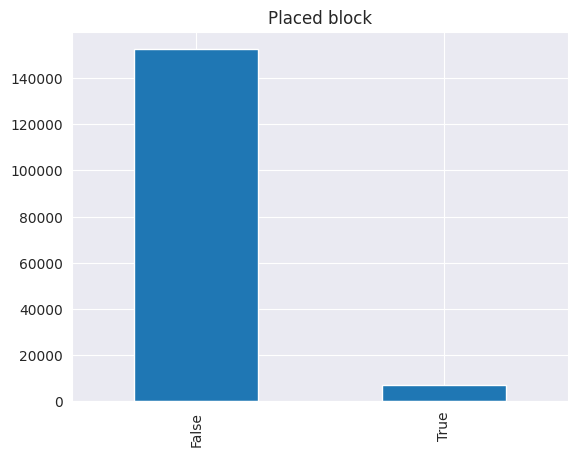

In [7]:
df['placed_block'].value_counts().plot(kind='bar', title='Placed block')

Чтобы повысить сбалансированность данных, добавим булевый признак `will_place`, истинный, если игрок поставлю блок в ближайшие 250 мс (5 игровых тиков).

Для этого сначала добавим признак `ticks_till_place`, равный числу игровых тиков до того, как игрок поставит блок там, куда он сейчас смотрит.

In [8]:
block_to_tick_placed = dict()

for tick in reversed(df.index):
  block = (df["block_x"][tick], df["block_y"][tick], df["block_z"][tick])
  if df["placed_block"][tick]:
      block_to_tick_placed[block] = tick
  df.loc[tick, "ticks_till_place"] = block_to_tick_placed[block] - tick if block in block_to_tick_placed else -1

In [9]:
df[['block_x', 'block_y', 'block_z', 'placed_block', 'ticks_till_place']].iloc[500:600]

,block_x,block_y,block_z,placed_block,ticks_till_place
500,19988.0,102.0,1989.0,False,33510.0
501,NaN,NaN,NaN,False,-1.0
502,NaN,NaN,NaN,False,-1.0
503,19985.0,100.0,1989.0,False,-1.0
504,19985.0,101.0,1988.0,False,-1.0
...,...,...,...,...,...
595,19966.0,106.0,1987.0,False,-1.0
596,NaN,NaN,NaN,False,-1.0
597,NaN,NaN,NaN,False,-1.0
598,NaN,NaN,NaN,False,-1.0


Из распределения значений в столбце `ticks_till_place` видно, что между тем, как игрок посмотрит на место, куда можно поставить блок, и поставит его, может пройти до $\frac{140 000}{60 \cdot 60 \cdot 20} \approx 1.94$ часов, что обусловлено тем, что эти два события могут происходить в различных эпизодах для случайно совпавших координат.

Text(0.5, 1.0, 'Ticks till place')

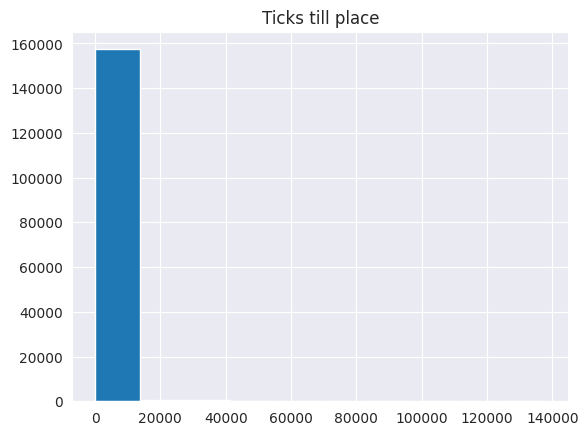

In [10]:
df['ticks_till_place'].hist()
plt.title('Ticks till place')

Чтобы избежать влияния независимых эпизодов друг на друга, ограничим `ticks_till_place` пятью игровыми тиками (250 мс), большие же значения заменим на `-1`.

In [11]:
df.loc[df['ticks_till_place'] > TICKS_PER_SECOND / 4, 'ticks_till_place'] = -1

<Axes: title={'center': 'Ticks till place'}>

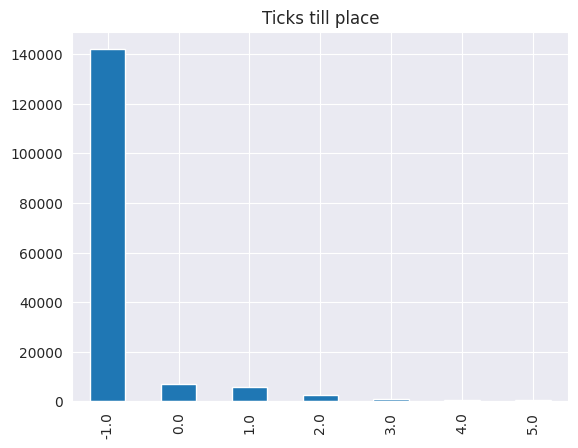

In [12]:
df['ticks_till_place'].value_counts().plot(kind='bar', title='Ticks till place')

Введём новый столбец `will_place`, соответствующий тому, поставит ли игрок блок в ближайшие 250 мс (5 игровых тиков) и будем использовать его в качестве целевого признака, так как для этого столбца значения `False` преобладают не так сильно, как для `placed_block`.

In [13]:
df['will_place'] = df['ticks_till_place'] != -1

<Axes: title={'center': 'Will place'}>

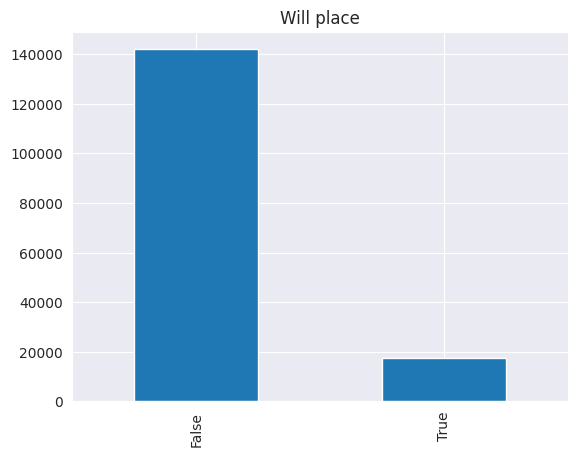

In [14]:
df['will_place'].value_counts().plot(kind='bar', title='Will place')

Добавим столбцы `vel_x`, `vel_y`, `vel_z`, соответствующие скорости движения и удалим первую запись, так как для неё нет предыдущей, чтобы вычислить скорость.

In [15]:
df['vel_x'] = df['x'] - df['x'].shift(1)
df['vel_y'] = df['y'] - df['y'].shift(1)
df['vel_z'] = df['z'] - df['z'].shift(1)

df = df.iloc[1:]

In [16]:
df[["x", "y", "z", "vel_x", "vel_y", "vel_z"]].iloc[500:600]

,x,y,z,vel_x,vel_y,vel_z
501,19988.334574,102.000000,1989.769827,-0.302515,0.000000,-0.015287
502,19988.056555,102.000000,1989.826022,-0.278020,0.000000,0.056196
503,19987.598761,102.420000,1989.862776,-0.457793,0.420000,0.036753
504,19987.324637,102.753200,1989.892428,-0.274124,0.333200,0.029652
505,19987.050066,103.001336,1989.926125,-0.274571,0.248136,0.033697
...,...,...,...,...,...,...
596,19966.825299,106.252203,1986.994695,-0.196996,0.003016,0.144863
597,19966.627158,106.176759,1987.143638,-0.198141,-0.075444,0.148942
598,19966.423929,106.024424,1987.290305,-0.203229,-0.152335,0.146667
599,19966.215267,106.000000,1987.433070,-0.208662,-0.024424,0.142765


Так как допустимо игнорировать все записи за 3 секунды до записи с флагом `missclick`, заменим старый признак `missclick` на новый, который принимает значение `True`, если старый признак `missclick` был равен `True` хоть в какой-то игровой тик в ближайшие 3 секунды.

<Axes: title={'center': 'Miss click (original)'}>

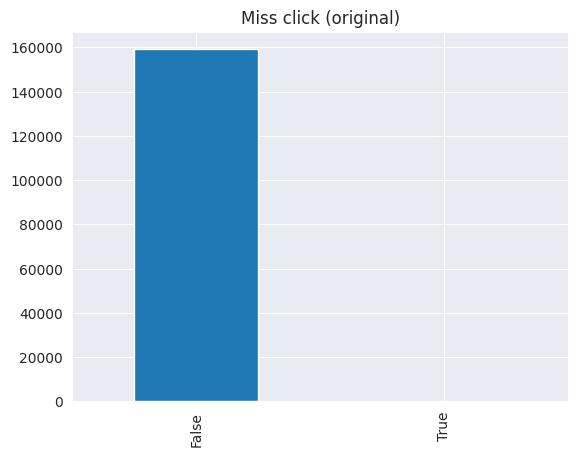

In [17]:
df['missclick'].value_counts().plot(kind='bar', title='Miss click (original)')

In [18]:
MISSCLICK_DURATION = TICKS_PER_SECOND * 3

last_missclick = df.shape[0] + MISSCLICK_DURATION

for tick in reversed(df.index):
  if df["missclick"][tick]:
      last_missclick = tick
  df.loc[tick, "missclick"] = last_missclick - tick < MISSCLICK_DURATION

<Axes: title={'center': 'Miss click (extended)'}>

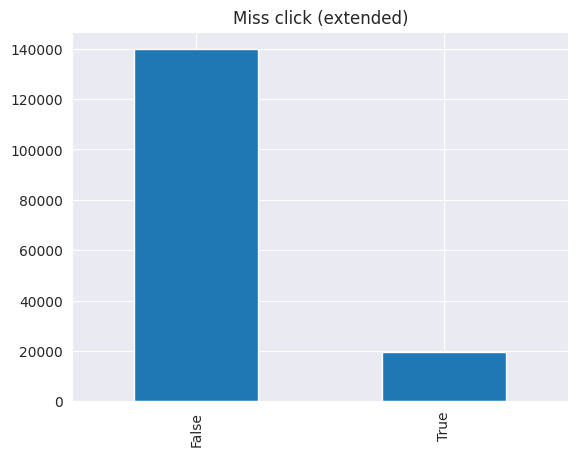

In [19]:
df['missclick'].value_counts().plot(kind='bar', title='Miss click (extended)')

Удалим записи с флагом `missclick`

In [20]:
df = df[df['missclick'] == False]

In [21]:
df.shape

(139727, 399)

Заметим, что игрок не может поставить блок пока летает во время возрождения, поэтому удалим записи с флагом `can_fly` (удаление тривиальных случаев по большей части мотивировано желанием узнать, какая точность предсказаний достижима, если учитывать только нетривиальные случаи).

<Axes: xlabel='placed_block', ylabel='can_fly'>

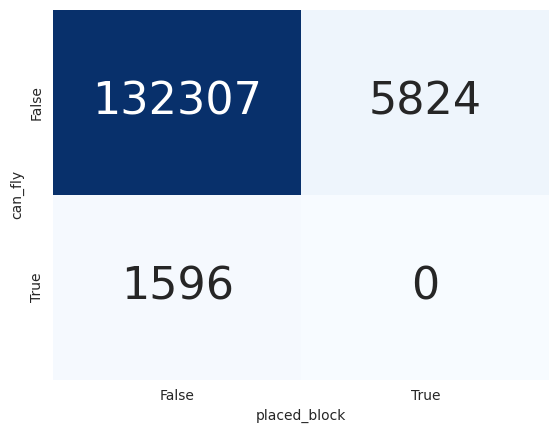

In [22]:
sns.heatmap(pd.crosstab(df['can_fly'], df['placed_block']),annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 32})

In [23]:
df = df[df['can_fly'] == False]

In [24]:
df.shape

(138131, 399)

Заметим, что игрок может поставить блок только, если держит его, поэтому удалим записи без флага `holds_block`

<Axes: xlabel='placed_block', ylabel='holds_block'>

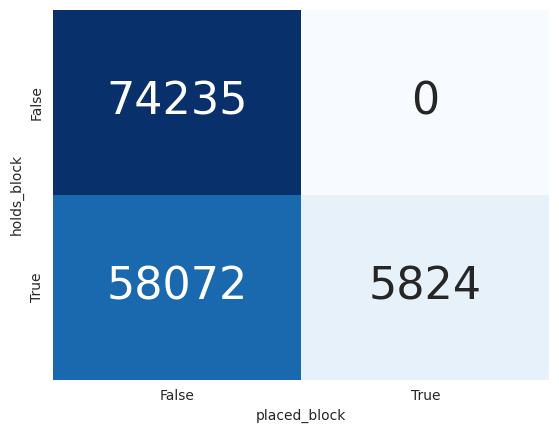

In [25]:
sns.heatmap(pd.crosstab(df['holds_block'], df['placed_block']),annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 32})

In [26]:
df = df[df['holds_block']]

In [27]:
df.shape

(63896, 399)

Заметим, что игрок не может поставить блок, когда не смотрит на блок, поэтому удалим записи содержащие `NaN` (в столбцах `block_x`, `block_y` и `block_z`)

<Axes: xlabel='placed_block', ylabel='has_none'>

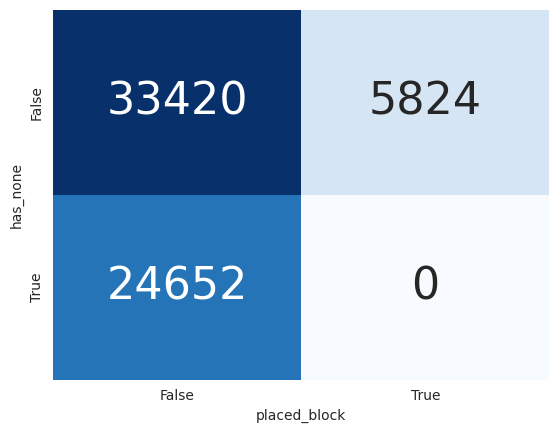

In [28]:
df['has_none'] = df.isnull().any(axis=1)
sns.heatmap(pd.crosstab(df['has_none'], df['placed_block']),annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 32})

In [29]:
df = df.dropna()

In [30]:
df.shape

(39244, 400)

Признаки `block_x` и `block_z` соответствуют координатам угла блока с наименьшими координатами, исправим это, добавив `0.5` (для `block_y` это не актуально, так как нижняя граница блока, в отличие от, например, северной границы блока, не является менее осмысленным признаком, чем середина блока)

In [31]:
df["block_x"] += 0.5
df["block_z"] += 0.5

In [32]:
df[["block_x", "block_y", "block_z"]].iloc[500:600]

,block_x,block_y,block_z
1752,99906.5,102.0,1988.5
1753,99906.5,102.0,1988.5
1754,99905.5,102.0,1988.5
1755,99905.5,102.0,1988.5
1756,99905.5,102.0,1988.5
...,...,...,...
1909,99876.5,106.0,1990.5
1910,99876.5,106.0,1990.5
1911,99876.5,106.0,1990.5
1912,99875.5,105.0,1990.5


Добавим признаки `rel_block_x`, `rel_block_y` и `rel_block_z`, соответствующие координатам блока относительно игрока

In [33]:
df["rel_block_x"] = df["block_x"] - df["x"]
df["rel_block_y"] = df["block_y"] - df["y"]
df["rel_block_z"] = df["block_z"] - df["z"]

Добавим флаг `inside_block`, истинный когда хитбокс игрока (0.6 x 1.8 x 0.6) пересекается с хитбоксом блока

In [34]:
df["inside_block"] = (-0.8 <= df["rel_block_x"]) & (df["rel_block_x"] <= 0.8) & (-0.8 <= df["rel_block_z"]) & (df["rel_block_z"] <= 0.8) & (0 <= df["rel_block_y"]) & (df["rel_block_y"] <= 1.8)

Заметим, что когда хитбоксы пересекаются, поставить блок невозможно, поэтому удалим записи с флагом `inside_block`

<Axes: xlabel='placed_block', ylabel='inside_block'>

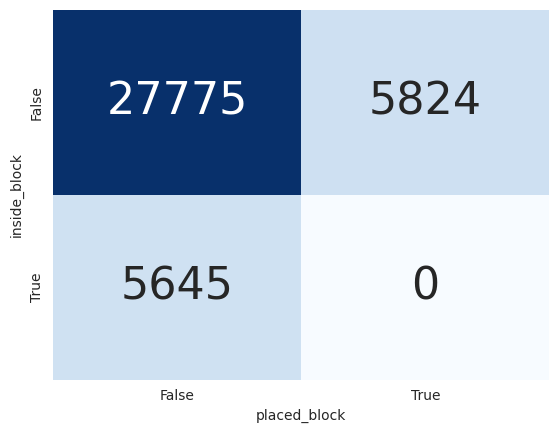

In [35]:
sns.heatmap(pd.crosstab(df['inside_block'], df['placed_block']),annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 32})

In [36]:
df = df[df['inside_block'] == False]
df.shape

(33599, 404)

После отфильтровывания тривиальных случаев, распределение целевого признака стало значительно более сбалансированным

<Axes: title={'center': 'Will place'}>

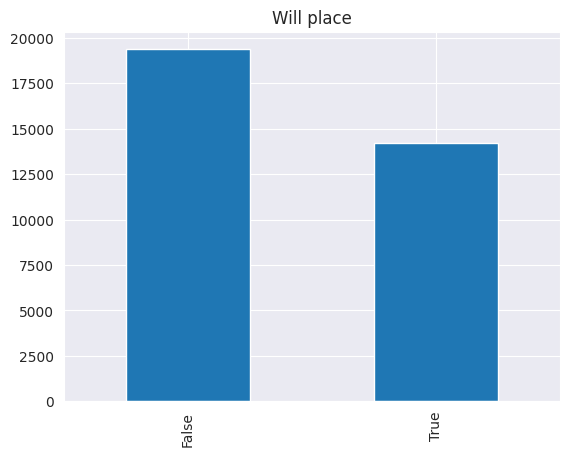

In [37]:
df['will_place'].value_counts().plot(kind='bar', title='Will place')

In [38]:
df['will_place'].mean()

0.4237626119824995

Проверим, симметричен ли набор данных относительно инверсии горизонтальных осей координат `x` и `z` и замены одной горизонтальной координаты на другую.

Как можно видеть из следующих двух гистограмм таких симметрий в наборе данных нет, хотя инверсия оси `z` потенциально может быть осмыслена.

Text(0.5, 1.0, 'Relative block x')

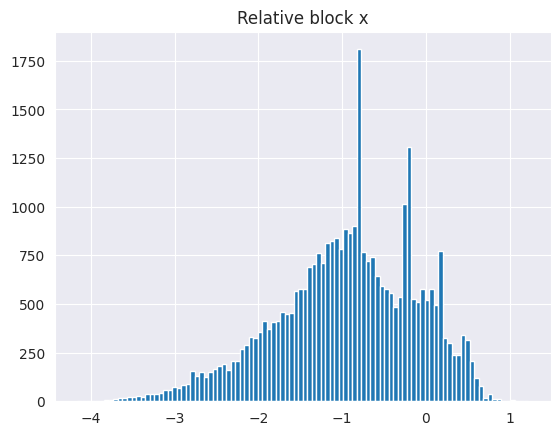

In [39]:
df['rel_block_x'].hist(bins=100)
plt.title('Relative block x')

Text(0.5, 1.0, 'Relative block z')

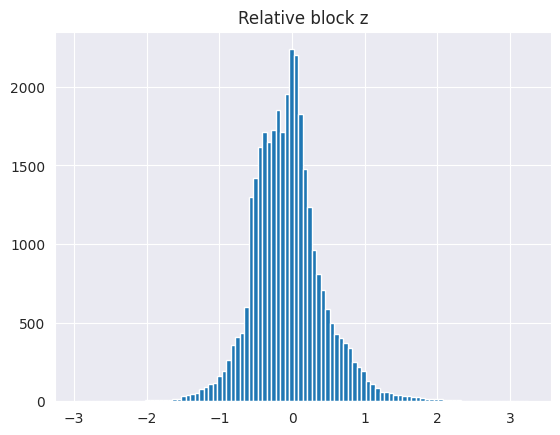

In [40]:
df['rel_block_z'].hist(bins=100)
plt.title('Relative block z')

Заметим, что при совершении нескольких оборотов по горизонтали, угл поворота накапливается, исправим это, взяв остаток от деления на `360`, также добавим признаки `yaw_sin` и `yaw_cos`, так как они могут быть более удобными для модели

Text(0.5, 1.0, 'Yaw')

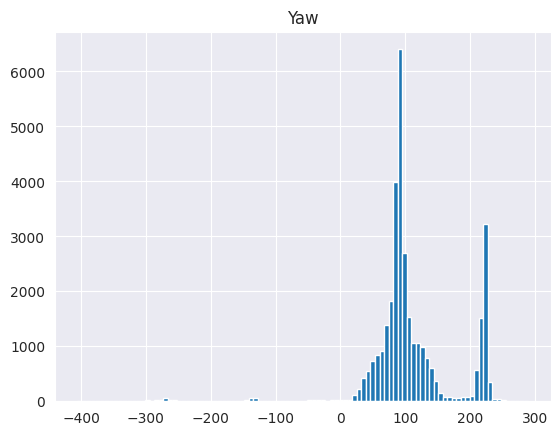

In [41]:
df['yaw'].hist(bins=100)
plt.title('Yaw')

In [42]:
df['yaw'] = df['yaw'] % 360.0

Text(0.5, 1.0, 'Yaw mod 360')

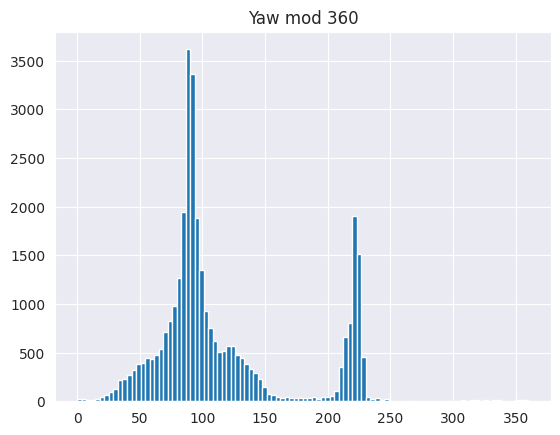

In [43]:
df['yaw'].hist(bins=100)
plt.title('Yaw mod 360')

In [44]:
df['yaw_sin'] = np.sin(np.radians(df['yaw']))
df['yaw_cos'] = np.cos(np.radians(df['yaw']))

Заметим из гистограмм координатных признаков, что в то время как признаки `y` и `z` принимают значения из довольно ограниченного диапазона и потенциально могут быть полезными, признак `x` по большей части определяется расположением самой игровой карты и может быть удалён

Text(0.5, 1.0, 'X')

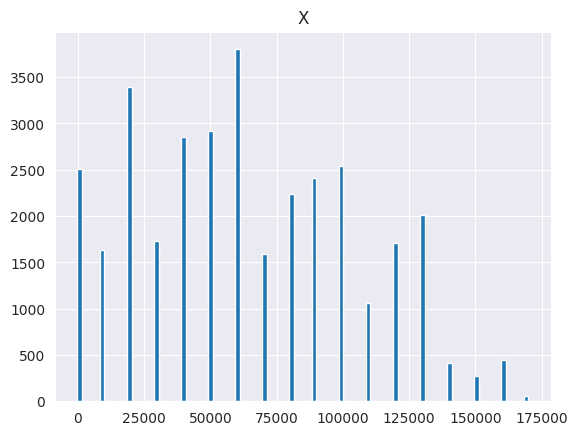

In [45]:
df['x'].hist(bins=100)
plt.title('X')

Text(0.5, 1.0, 'Z')

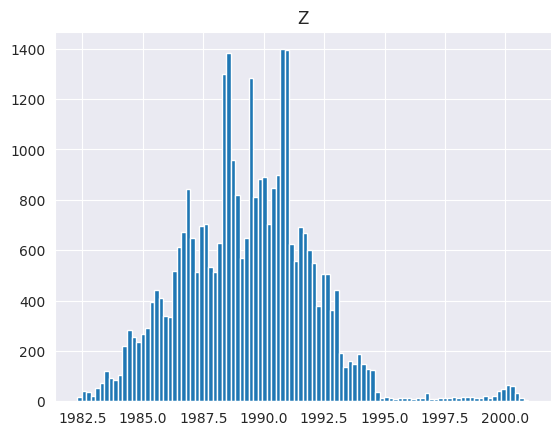

In [46]:
df['z'].hist(bins=100)
plt.title('Z')

Text(0.5, 1.0, 'Y')

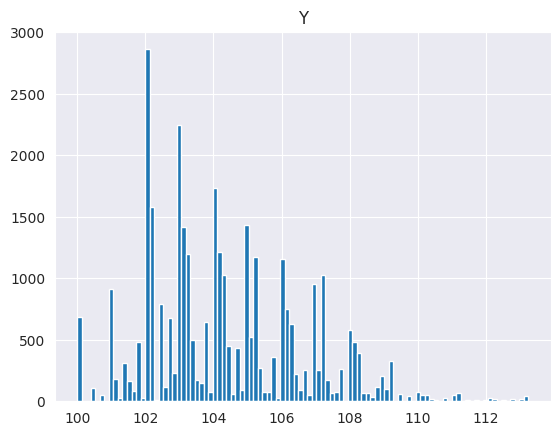

In [47]:
df['y'].hist(bins=100)
plt.title('Y')

Для всех координатных признаков, добавим признаки соответствующие их дробным частям, так как дробные части определяют, в какой части блока находится игрок и потенциально могут быть полезными. Это так же подтверждается их гистограммами, которые не являются равномерными распределениями.

In [48]:
df['x_frac'] = df['x'] % 1.0
df['y_frac'] = df['y'] % 1.0
df['z_frac'] = df['z'] % 1.0

Text(0.5, 1.0, 'Fractional part of X')

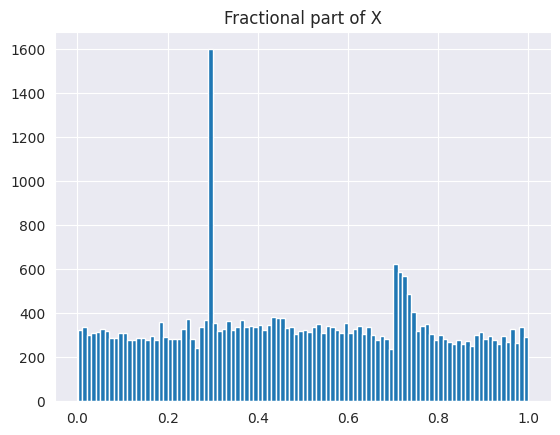

In [49]:
df['x_frac'].hist(bins=100)
plt.title('Fractional part of X')

Text(0.5, 1.0, 'Fractional part of Y')

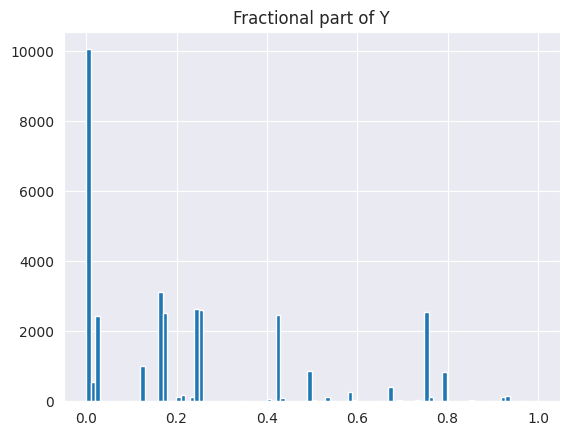

In [50]:
df['y_frac'].hist(bins=100)
plt.title('Fractional part of Y')

Text(0.5, 1.0, 'Fractional part of Z')

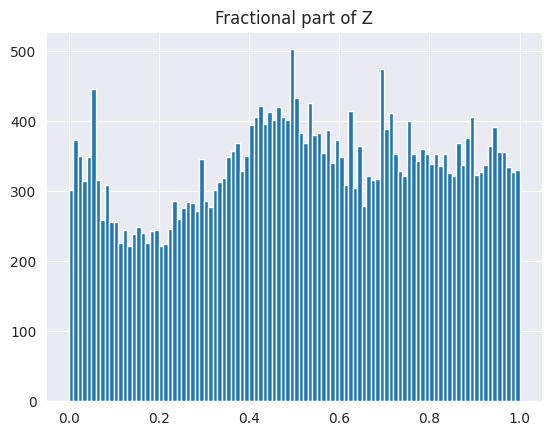

In [51]:
df['z_frac'].hist(bins=100)
plt.title('Fractional part of Z')

Посмотрим на корреляцию целевого признака с остальными. Удалим константные признаки, в частности `player[0][0][0]` и `player[0][1][0]`, которые всегда ложные, так как они соответствуют блокам, которые пересекаются соответственно с ногами и головой игрока.

In [52]:
pd.DataFrame({"Corr with will_place": df.corrwith(df["will_place"]), "Mean": df.mean()}).sort_values(by=['Corr with will_place'])

,Corr with will_place,Mean
rel_block_y,-0.486085,-0.801421
block[0][-1][0],-0.427756,0.655496
player[-1][-1][0],-0.344181,0.325426
middle[0][-1][0],-0.337575,0.545225
player[0][-1][0],-0.290272,0.370755
...,...,...
missclick,NaN,0.000000
player[0][0][0],NaN,0.000000
player[0][1][0],NaN,0.000000
has_none,NaN,0.000000


In [53]:
df.drop(['player[0][0][0]', 'player[0][1][0]', 'holds_block', 'can_fly', 'missclick', 'has_none', 'inside_block'], axis=1, inplace=True)

Посмотрим на абсолютные средние значения признаков. Заметим, что признак `block[0][0][0]` почти всегда ложный, удалим его, так как он недопредставлен в имеющихся данных.

In [54]:
pd.DataFrame({"Corr with will_place": df.corrwith(df["will_place"]), "Absolute mean": np.abs(df.mean())}).sort_values(by=['Absolute mean'])

,Corr with will_place,Absolute mean
block[0][0][0],-0.035039,0.001667
vel_z,-0.007930,0.003553
middle[0][1][0],0.001113,0.006637
block[0][1][0],-0.035087,0.007084
middle[1][1][0],-0.025994,0.009881
...,...,...
yaw,0.185888,116.131067
block_z,-0.008193,1989.273654
z,0.002296,1989.334400
block_x,0.019426,63948.493571


In [55]:
df.drop(['block[0][0][0]'], axis=1, inplace=True)

Построим таблицу корреляции всех признаков, не являющихся массивами, друг с другом

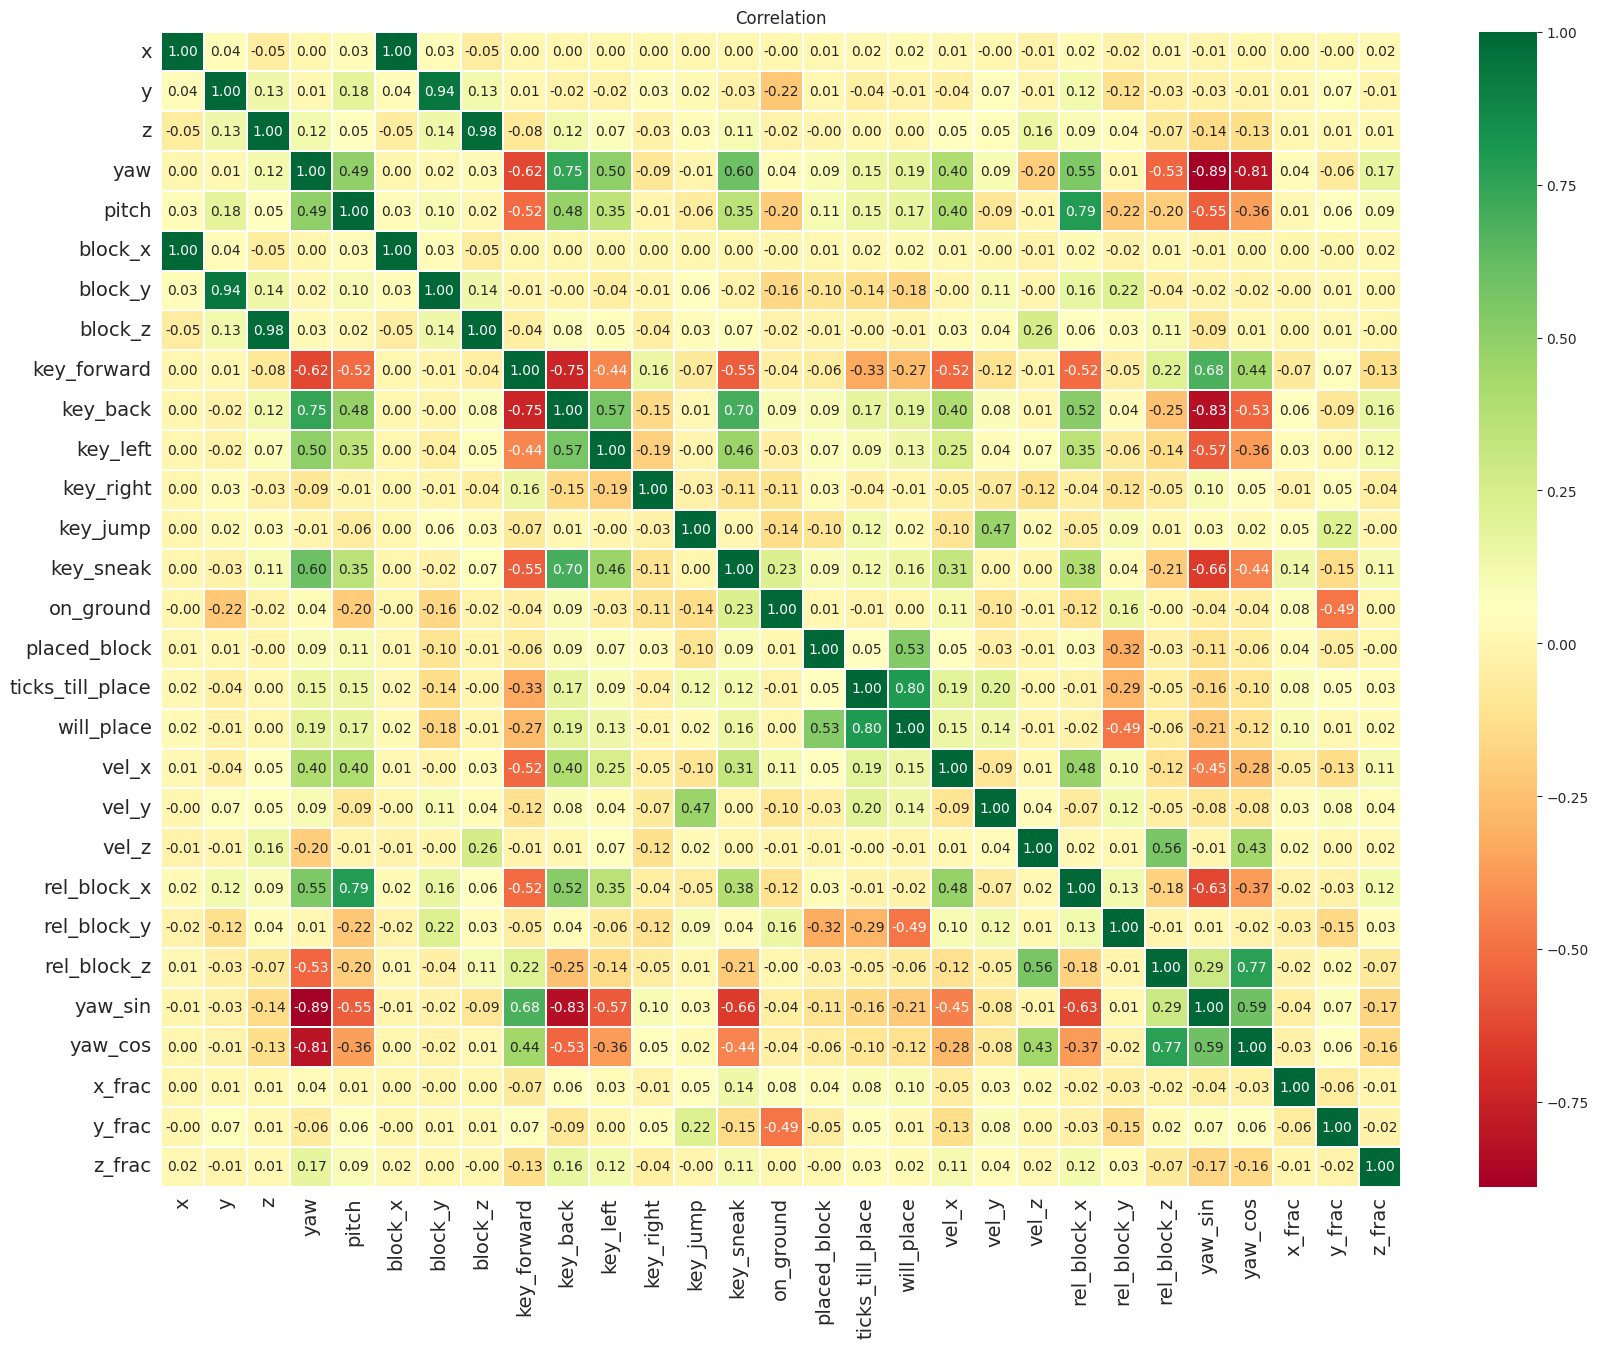

In [56]:
sns.heatmap(df[[col for col in df.columns.values if '[' not in col]].corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10}, fmt='.2f', xticklabels=1, yticklabels=1)
fig = plt.gcf()
fig.set_size_inches(20, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Correlation')
plt.show()

Удалим признаки, заменённые другими

In [57]:
df.drop(['block_x', 'block_y', 'block_z', 'placed_block', 'ticks_till_place', 'x'], axis=1, inplace=True)

Заметим, что игрок движется в направлении уменьшения координаты `x`, поэтому удалим признаки, кодирующие наличие блоков за игроком (с большей координатой `x`)

Text(0.5, 1.0, 'Velocity X')

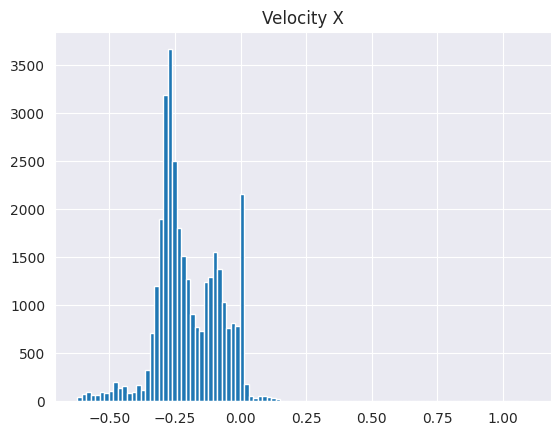

In [58]:
df['vel_x'].hist(bins=100)
plt.title('Velocity X')

In [59]:
df.drop([col for col in df.columns.values if col.startswith('player[1') or col.startswith('player[2')], axis=1, inplace=True)

Сохраним обработанный набор данных

In [60]:
df.shape

(33599, 345)

In [61]:
df.to_csv("prepared_place.csv", index=False)